<a href="https://colab.research.google.com/github/Risheek-H/Sentiment-Analysis/blob/main/MLFINAL_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **About Dataset**


This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api.

 **It contains the following 6 fields:**


target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

ids: The id of the tweet ( 2087)

date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

flag: The query (lyx). If there is no query, then this value is NO_QUERY.

user: the user that tweeted (robotickilldozr)

text: the text of the tweet (Lyx is cool)


In [ ]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

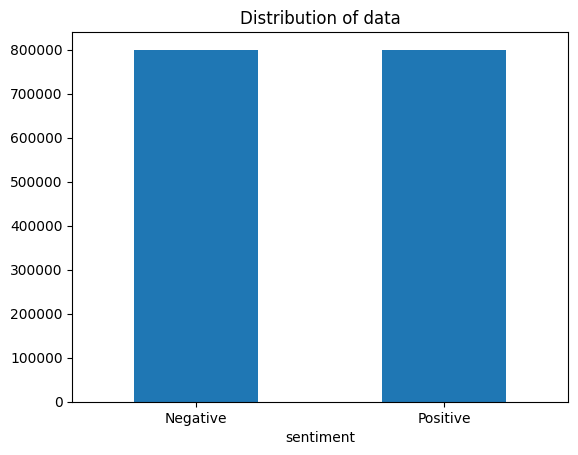

In [ ]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('/content/drive/MyDrive/MLPROJECT/training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

In [ ]:
# Printing the count of each sentiment class.
sentiment_counts = dataset['sentiment'].value_counts()
print("Count of Negative Sentiments:", sentiment_counts[0])
print("Count of Positive Sentiments:", sentiment_counts[1])

Count of Negative Sentiments: 800000
Count of Positive Sentiments: 800000


In [ ]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

1.Converts the tweet to lowercase.

2.Applies the URL pattern replacement.

3.Replaces emojis with corresponding meanings(prefixing with 'EMOJI').

4.Applies the mention pattern replacement.

5.Replaces non-alphabetic characters.

6.Replaces consecutive sequences of characters.

7.Lemmatizes each word in the tweet.

8.Appends the processed tweet to the processedText list.




In [ ]:
def preprocess(textdata):
    processedText = []

    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()

    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    for tweet in textdata:
        tweet = tweet.lower()

        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')

        processedText.append(tweetwords)

    return processedText

In [ ]:
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 164 seconds


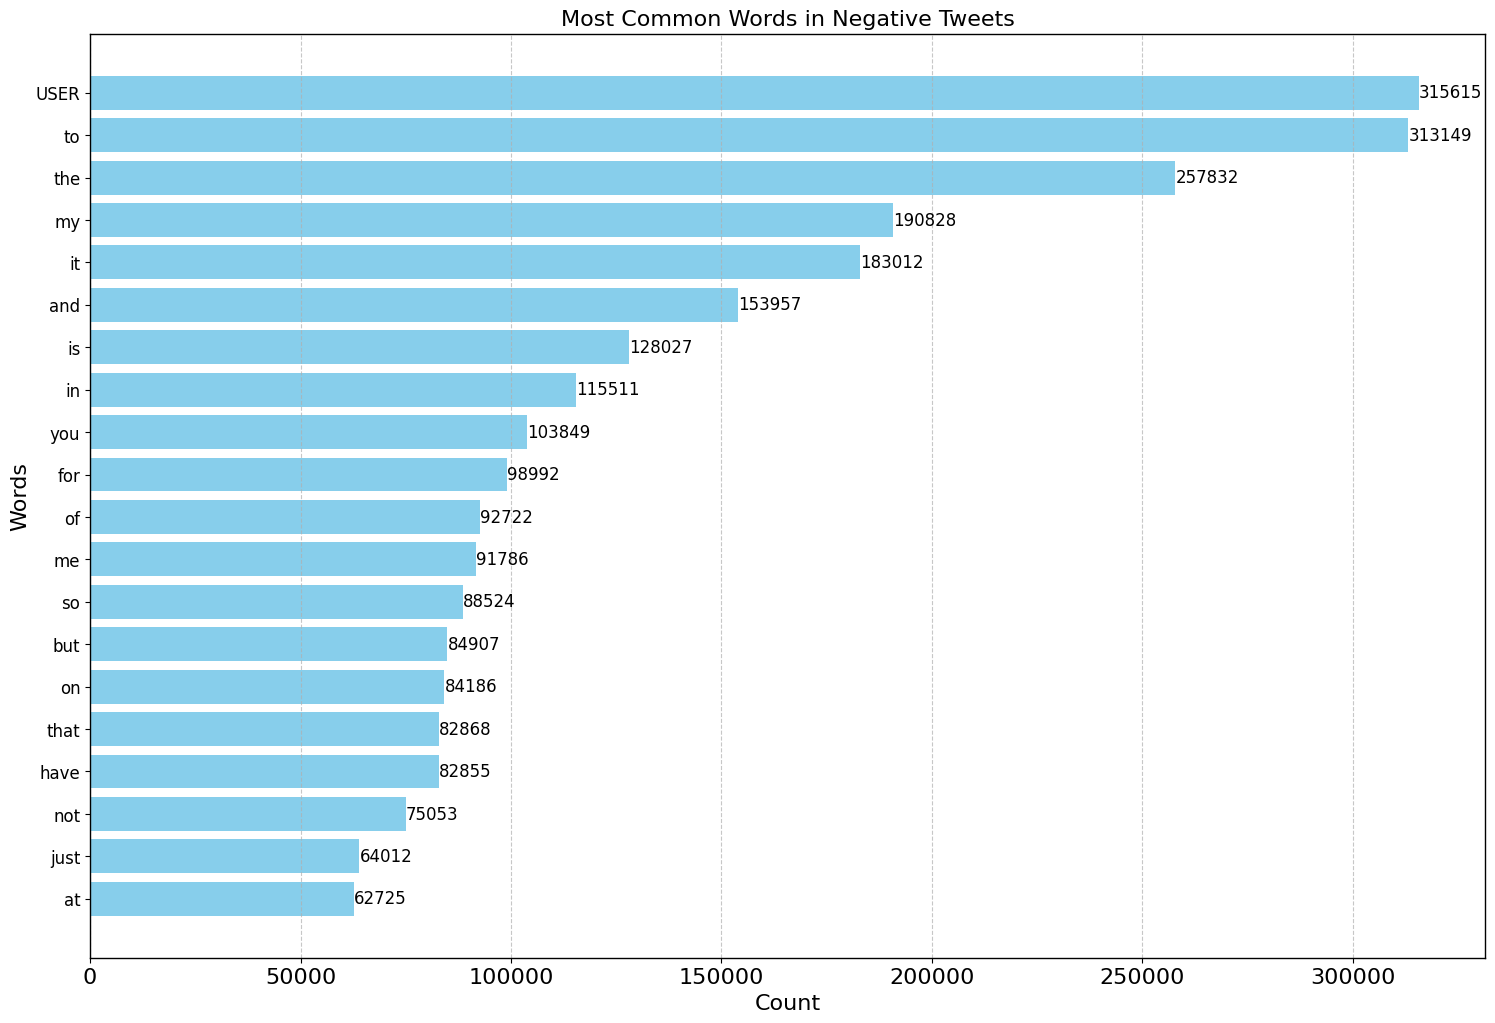

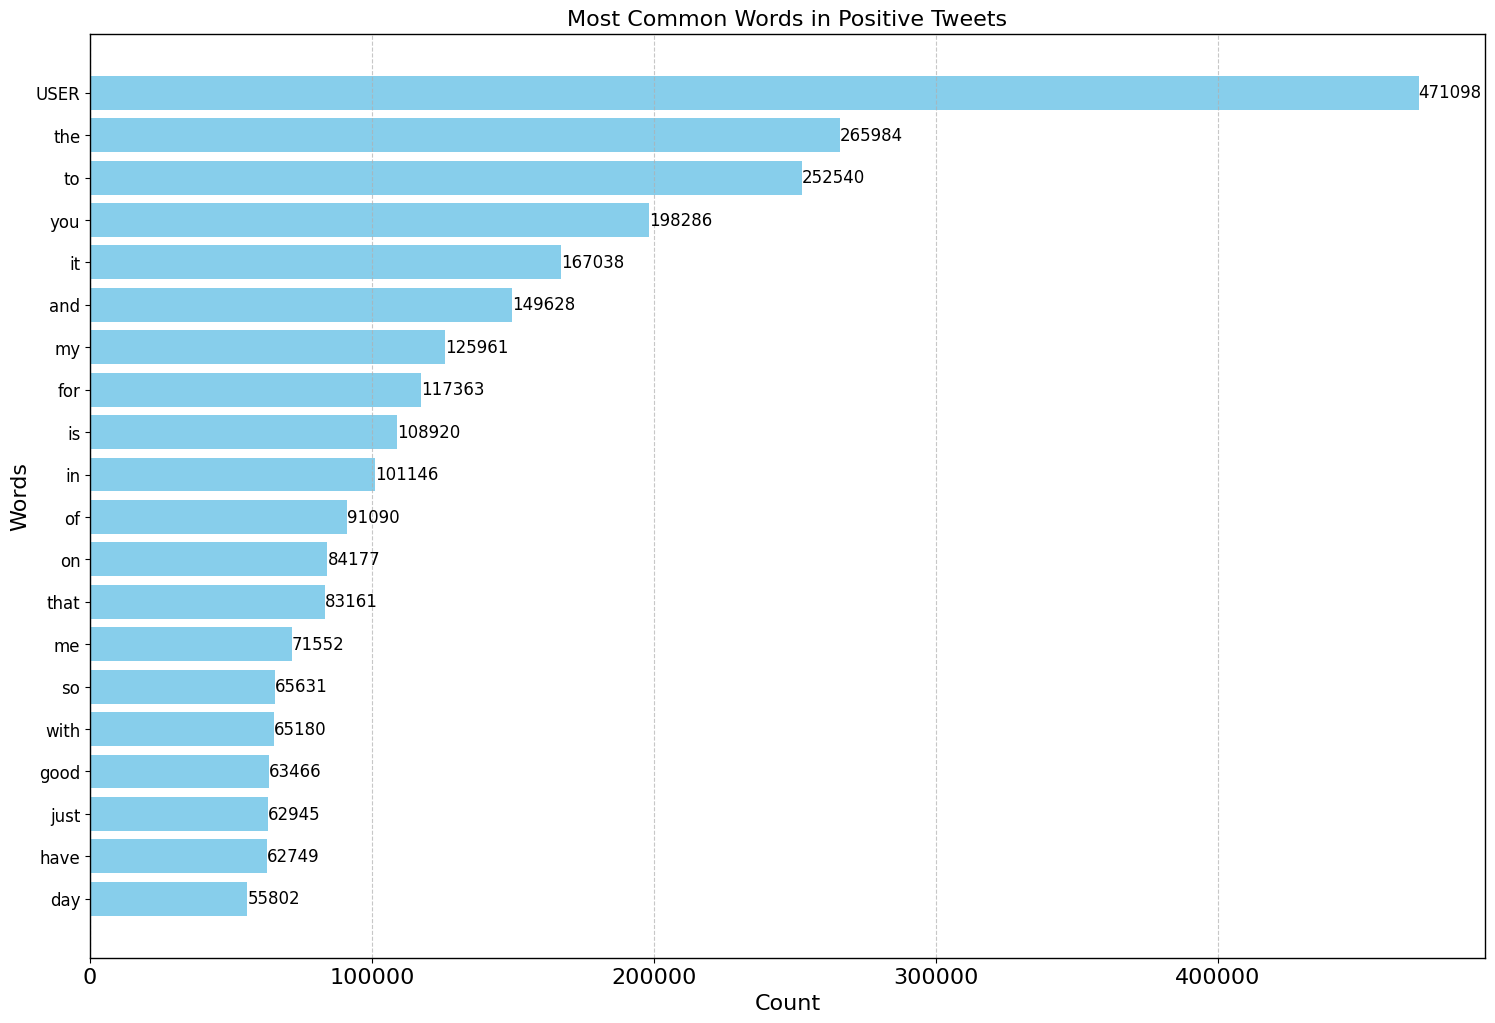

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Assuming processedtext is the list of processed text for all tweets.

# Split the processedtext into negative and positive parts
data_neg = processedtext[:800000]
data_pos = processedtext[800000:]

# Function to plot most common words
def plot_most_common_words(data, title):
    # Join all the processed text into a single string
    all_text = " ".join(data)

    # Tokenize the text into words
    words = all_text.split()

    # Count the occurrences of each word
    word_counts = Counter(words)

    # Get the most common words and their counts
    common_words = word_counts.most_common(20)

    # Extract words and counts for plotting
    words, counts = zip(*common_words)

    # Plot the bar chart
    plt.figure(figsize=(18, 12))  # Adjusted figure size for better readability
    bars = plt.barh(words, counts, color='skyblue')  # Horizontal bar chart
    plt.ylabel('Words', fontsize=16)  # Swapped xlabel and ylabel
    plt.xlabel('Count', fontsize=16)  # Swapped xlabel and ylabel
    plt.title(title, fontsize=16)
    plt.xticks(fontsize=16)  # Adjusted fontsize for better readability
    plt.yticks(fontsize=12)  # Adjusted fontsize for better readability

    # Annotate each bar with its count value
    for bar, count in zip(bars, counts):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
                 count, ha='left', va='center', fontsize=12)

    plt.gca().invert_yaxis()  # Invert y-axis to have highest count at the top
    plt.grid(axis='x', linestyle='--', alpha=0.7)  # Adding grid lines for better readability

    # Increase the size of the border
    plt.gca().spines['top'].set_linewidth(1)
    plt.gca().spines['right'].set_linewidth(1)
    plt.gca().spines['bottom'].set_linewidth(1)
    plt.gca().spines['left'].set_linewidth(1)

    plt.show()

# Plot most common words for negative tweets
plot_most_common_words(data_neg, 'Most Common Words in Negative Tweets')

# Plot most common words for positive tweets
plot_most_common_words(data_pos, 'Most Common Words in Positive Tweets')


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF VECTORIZER
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)
vectorizer.fit(X_train)
print('Vectorizer fitted.')
print('No. of feature_words: ', len(vectorizer.get_feature_names_out()))


Vectorizer fitted.
No. of feature_words:  500000


In [ ]:
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)
print(f'Data Transformed.')


Data Transformed.


In [ ]:
def model_Evaluate(model):

    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.82      0.81      0.82     39989
           1       0.81      0.83      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



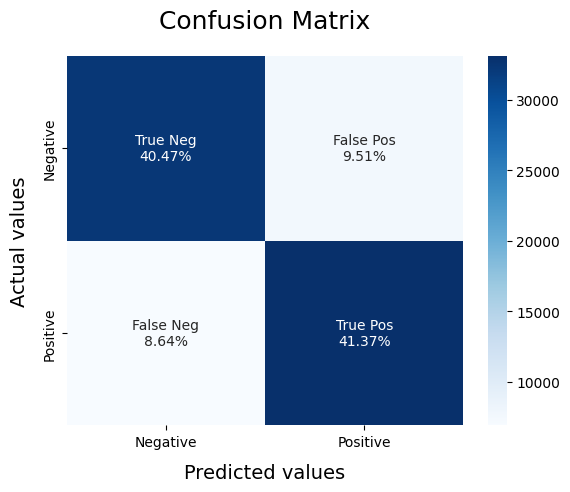

In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     39989
           1       0.82      0.84      0.83     40011

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



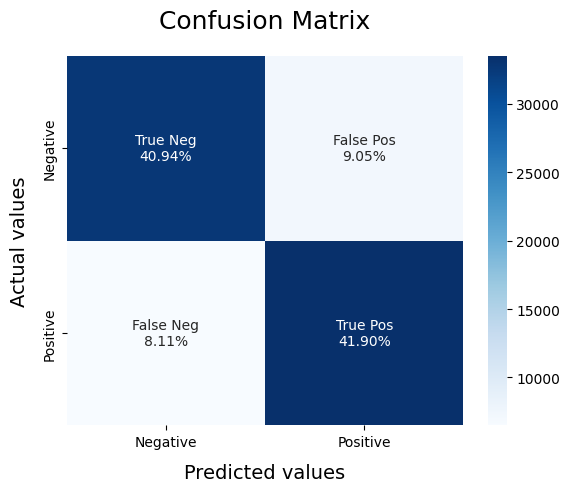

In [ ]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Sample training data
X_train = ["I feel great today!", "This movie is fantastic.", "I'm not happy with the service."]
y_train = [1, 1, 0]  # Assuming binary labels (1: Positive, 0: Negative)

# Create TF-IDF vectorizer for unigrams


vectorizer = TfidfVectorizer(ngram_range=(1, 1))  # Use (1, 1) for unigrams
X_train_vectorized = vectorizer.fit_transform(X_train)

# Save the TF-IDF vectorizer using joblib
joblib.dump(vectorizer, '/content/drive/MyDrive/MLPROJECT/vectoriser-unigram.joblib')

# Train and save Logistic Regression model
LRmodel = LogisticRegression()
LRmodel.fit(X_train_vectorized, y_train)
joblib.dump(LRmodel, '/content/drive/MyDrive/MLPROJECT/logistic_regression_model.joblib')

# Train and save Linear SVM model
SVCmodel = LinearSVC()
SVCmodel.fit(X_train_vectorized, y_train)
joblib.dump(SVCmodel, '/content/drive/MyDrive/MLPROJECT/linear_svm_model.joblib')

# Sample new text data for prediction
new_text_data = ["I feel great today!", "This movie is fantastic.", "I'm not happy with the service."]

# Load the TF-IDF vectorizer
vectorizer = joblib.load('/content/drive/MyDrive/MLPROJECT/vectoriser-unigram.joblib')

# Transform the new text data using the loaded vectorizer
new_text_vectorized = vectorizer.transform(new_text_data)

# Load the Logistic Regression model
LRmodel = joblib.load('/content/drive/MyDrive/MLPROJECT/logistic_regression_model.joblib')

# Predict sentiment using Logistic Regression model
LR_predictions = LRmodel.predict(new_text_vectorized)

# Load the Linear SVM model
SVCmodel = joblib.load('/content/drive/MyDrive/MLPROJECT/linear_svm_model.joblib')

# Predict sentiment using Linear SVM model
SVC_predictions = SVCmodel.predict(new_text_vectorized)

# Convert predictions to DataFrame for better visualization
result_df = pd.DataFrame({
    'Text': new_text_data,
    'LR Prediction': np.where(LR_predictions == 1, 'Positive', 'Negative'),
    'SVM Prediction': np.where(SVC_predictions == 1, 'Positive', 'Negative')
})

# Save the result DataFrame to a CSV file
result_df.to_csv('/content/drive/MyDrive/MLPROJECT/sentiment_predictions.csv', index=False)

# Print the result DataFrame
print(result_df)

                              Text LR Prediction SVM Prediction
0              I feel great today!      Positive       Positive
1         This movie is fantastic.      Positive       Positive
2  I'm not happy with the service.      Positive       Negative



### BERT

>



In [ ]:
!pip install transformers



In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.nn.functional import softmax
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np


In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoConfig, BertModel, BertConfig, BertTokenizer, BertForSequenceClassification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from transformers import AutoConfig
config = AutoConfig.from_pretrained('bert-base-uncased')
#model =  AutoModel.from_config(config)

# # Load pre-trained BERT model for sequence classification
# model = BertModel.from_pretrained('bert-base-uncased')
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# # Create a configuration with default values (not pre-trained)
# config = BertConfig()

# # Create an instance of the BERT model with the default configuration
model = BertModel(config)

# Create an instance of the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to encode text data for BERT model
def encode_text(text):
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors='pt')
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings

# Sample training data
X_train = ["I feel great today!", "This movie is fantastic.", "I'm not happy with the service."]
y_train = [1, 1, 0] # Assuming binary labels (1: Positive, 0: Negative)

# Generate BERT embeddings for the training data
X_train_embeddings = encode_text(X_train)

# Train and save Logistic Regression model
LRmodel = LogisticRegression()
LRmodel.fit(X_train_embeddings, y_train)
torch.save(LRmodel, '/content/drive/MyDrive/MLPROJECT/logistic_regression_model.pth')

# Train and save Linear SVM model
SVCmodel = LinearSVC()
SVCmodel.fit(X_train_embeddings, y_train)
torch.save(SVCmodel, '/content/drive/MyDrive/MLPROJECT/linear_svm_model.pth')

# Sample new text data for prediction
new_text_data = ["great, but not happy today!", "movie is bad.", "very delighted with the service."]

# Generate BERT embeddings for the new text data
new_text_embeddings = encode_text(new_text_data)

# Load the Logistic Regression model
LRmodel = torch.load('/content/drive/MyDrive/MLPROJECT/logistic_regression_model.pth')

# Predict sentiment using Logistic Regression model
LR_predictions = LRmodel.predict(new_text_embeddings)

# Load the Linear SVM model
SVCmodel = torch.load('/content/drive/MyDrive/MLPROJECT/linear_svm_model.pth')

# Predict sentiment using Linear SVM model
SVC_predictions = SVCmodel.predict(new_text_embeddings)

# Convert predictions to DataFrame for better visualization
result_df = pd.DataFrame({
    'Text': new_text_data,
    'LR Prediction': np.where(LR_predictions == 1, 'Positive', 'Negative'),
    'SVM Prediction': np.where(SVC_predictions == 1, 'Positive', 'Negative')
})

# Save the result DataFrame to a CSV file
result_df.to_csv('/content/drive/MyDrive/MLPROJECT/sentiment_predictions.csv', index=False)

# Print the result DataFrame
print(result_df)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

                               Text LR Prediction SVM Prediction
0       great, but not happy today!      Positive       Positive
1                     movie is bad.      Positive       Positive
2  very delighted with the service.      Positive       Negative


In [ ]:
# model

In [ ]:
import torch.nn as nn
from transformers import BertModel, BertPreTrainedModel, BertConfig

class CustomBertForSequenceClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        # Customize the classifier head layers
        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size, 256),  # Change the hidden size
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, config.num_labels)  # Use config.num_labels
        )

        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
        )

        pooled_output = outputs[1]  # Take the [CLS] token output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:]  # Add hidden states and attention if they are here

        return logits

# Create a config with the number of labels
num_labels = 2  # Change this to the number of labels you have (e.g., 2 for binary classification)
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=num_labels)

# Create an instance of the custom model
model = CustomBertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.0.bias', 'classifier.3.bias', 'classifier.3.weight', 'classifier.0.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install tqdm


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your dataset
DATASET_COLUMNS = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('/content/drive/MyDrive/MLPROJECT/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)

# Map labels for binary classification: 0 for negative, 1 for positive sentiment
dataset['sentiment'] = dataset['sentiment'].map({0: 0, 4: 1})

# Sample 10,000 tuples from the dataset while maintaining the distribution
sampled_dataset = dataset.sample(n=1000, random_state=42)

# Split the sampled dataset into training+validation and test sets
train_valid_df, test_df = train_test_split(sampled_dataset, test_size=0.2, random_state=42)

# Further split the training+validation set into training and validation sets
train_df, valid_df = train_test_split(train_valid_df, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# The split is now: 60% training, 20% validation, 20% test


In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Load your dataset
DATASET_COLUMNS = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('/content/drive/MyDrive/MLPROJECT/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)

# Map labels for binary classification: 0 for negative, 1 for positive sentiment
dataset['sentiment'] = dataset['sentiment'].map({0: 0, 4: 1})

# Sample 20,000 tuples from the dataset while maintaining the distribution
sampled_dataset = dataset.sample(n=10000, random_state=42)

# Split the sampled dataset into training+validation and test sets
train_valid_df, test_df = train_test_split(sampled_dataset, test_size=0.2, random_state=42)

# Further split the training+validation set into training and validation sets
train_df, valid_df = train_test_split(train_valid_df, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Define DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# # Custom dataset class for PyTorch
# class CustomDataset(Dataset):
#     def __init__(self, dataframe, tokenizer, max_length=128):
#         self.data = dataframe
#         self.tokenizer = tokenizer
#         self.max_length = max_length

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, index):
#         text = self.data.iloc[index]['text']
#         label = self.data.iloc[index]['sentiment']

#         inputs = self.tokenizer(
#             text,
#             truncation=True,
#             padding='max_length',
#             max_length=self.max_length,
#             return_tensors='pt'
#         )

#         return {
#             'input_ids': inputs['input_ids'].flatten(),
#             'attention_mask': inputs['attention_mask'].flatten(),
#             'label': torch.tensor(label, dtype=torch.long)
#         }

# # Create datasets and data loaders for training, validation, and testing
# train_dataset = CustomDataset(train_df, tokenizer)
# valid_dataset = CustomDataset(valid_df, tokenizer)
# test_dataset = CustomDataset(test_df, tokenizer)  # Test dataset
# batch_size = 32
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
# test_loader = DataLoader(test_dataset, batch_size=batch_size)  # Test DataLoader

# # Define custom DistilBERT model for sequence classification
# class CustomDistilBertForSequenceClassification(DistilBertForSequenceClassification):
#     def forward(self, input_ids, attention_mask):
#         outputs = super().forward(input_ids=input_ids, attention_mask=attention_mask)
#         return outputs.logits

# # Initialize the custom DistilBERT model
# model = CustomDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
# optimizer = AdamW(model.parameters(), lr=2e-5)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # Training Loop
# num_epochs = 5
# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0

#     train_loader = tqdm(DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
#                         desc=f"Epoch {epoch + 1}/{num_epochs}", ncols=100)

#     for batch in train_loader:
#         input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['label'].to(device)
#         optimizer.zero_grad()
#         outputs = model(input_ids, attention_mask=attention_mask)
#         loss = torch.nn.functional.cross_entropy(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()

#     avg_loss = total_loss / len(train_loader)
#     print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

# # Save the fine-tuned model
# torch.save(model.state_dict(), 'distilbert_custom_model.pth')

# # The model is now ready for predictions on new data and can


In [ ]:
import torch
import torch.nn as nn
from transformers import DistilBertTokenizer, DistilBertModel, AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Define DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Custom dataset class for PyTorch
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['text']
        label = self.data.iloc[index]['sentiment']

        inputs = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Assuming train_df and valid_df are already defined as DataFrame objects
train_dataset = CustomDataset(train_df, tokenizer)
valid_dataset = CustomDataset(valid_df, tokenizer)
batch_size =16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

# Custom DistilBERT model for sequence classification with modified final layers
class CustomDistilBertForSequenceClassification(nn.Module):
    def __init__(self, num_labels=2):
        super(CustomDistilBertForSequenceClassification, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.pre_classifier = nn.Linear(self.distilbert.config.dim, self.distilbert.config.dim)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.distilbert.config.dim, num_labels)

    def forward(self, input_ids, attention_mask):
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = distilbert_output[0]
        pooled_output = hidden_state[:, 0]
        pooled_output = self.pre_classifier(pooled_output)
        pooled_output = nn.ReLU()(pooled_output)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

# Initialize the custom DistilBERT model
model = CustomDistilBertForSequenceClassification(num_labels=2)
optimizer = AdamW(model.parameters(), lr=2e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    train_loader = tqdm(DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
                        desc=f"Epoch {epoch + 1}/{num_epochs}", ncols=100)

    for batch in train_loader:
        input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

# # Save the fine-tuned model
torch.save(model.state_dict(), 'custom_distilbert_model.pth')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

NameError: name 'train_df' is not defined

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

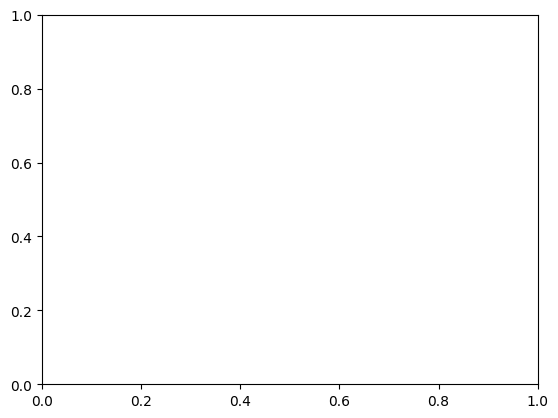

In [ ]:
import matplotlib.pyplot as plt

# Save the fine-tuned model
torch.save(model.state_dict(),'custom_distilbert_model.pth')

# Plotting the training loss
plt.plot(loss,label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


In [ ]:
# Assuming test_df is already defined as a DataFrame object
test_dataset = CustomDataset(test_df, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Function to evaluate the model on the test set
def evaluate(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = torch.nn.functional.cross_entropy(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, dim=1)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = correct_predictions / len(test_loader.dataset)
    return avg_loss, accuracy

# Evaluate the model
test_loss, test_accuracy = evaluate(model, test_loader, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.5957, Test Accuracy: 0.8550


In [ ]:
# Load the fine-tuned model
model_path = 'custom_distilbert_model.pth'
model = CustomDistilBertForSequenceClassification(num_labels=2)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()  # Set the model to evaluation mode


In [ ]:
def predict_sentiment(text, model, tokenizer, max_length=128):
    # Tokenize the input text and convert to a tensor
    inputs = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )

    # Move tensors to the same device as the model
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # No need to compute gradients during prediction
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    # Convert outputs to probabilities using softmax
    probabilities = torch.nn.functional.softmax(outputs, dim=1)

    # Choose the label with the highest probability
    prediction = torch.argmax(probabilities, dim=1).cpu().numpy()

    # Convert prediction to sentiment
    sentiment = 'positive' if prediction == 1 else 'negative'
    return sentiment, probabilities[0].cpu().numpy()

# Example usage
sample_text = "Risheek is a good boy"
sentiment, probabilities = predict_sentiment(sample_text, model, tokenizer)
print(f"Sentiment: {sentiment}, Probabilities: {probabilities}")


Sentiment: positive, Probabilities: [0.0172951  0.98270494]


Second part

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your dataset
DATASET_COLUMNS = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('/content/drive/MyDrive/MLPROJECT/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)

# Map labels for binary classification: 0 for negative, 1 for positive sentiment
dataset['sentiment'] = dataset['sentiment'].map({0: 0, 4: 1})

# Sample a larger number of tuples from the dataset
# Adjust the sample size as needed
sampled_dataset = dataset.sample(n=1000, random_state=42)

# Split the sampled dataset into training and test sets (80-20 split)
train_data, test_df = train_test_split(sampled_dataset, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets
# Here we reserve 20% of the training data for validation
train_df, valid_df = train_test_split(train_data, test_size=0.2, random_state=42)

# Now you have train_df, valid_df, and test_df


In [ ]:
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
import torch
import torch.nn as nn
from transformers import DistilBertTokenizer, DistilBertModel, AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
class CustomDistilBertForSequenceClassification(nn.Module):
    def __init__(self, num_labels=2):
        super(CustomDistilBertForSequenceClassification, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.pre_classifier = nn.Linear(self.distilbert.config.dim, self.distilbert.config.dim)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.distilbert.config.dim, num_labels)

    def forward(self, input_ids, attention_mask):
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = distilbert_output[0]
        pooled_output = hidden_state[:, 0]
        pooled_output = self.pre_classifier(pooled_output)
        pooled_output = nn.ReLU()(pooled_output)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

model = CustomDistilBertForSequenceClassification(num_labels=2)
optimizer = AdamW(model.parameters(), lr=2e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


CustomDistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=Fa

In [ ]:
# Custom dataset class for PyTorch
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['text']
        label = self.data.iloc[index]['sentiment']

        inputs = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# Create datasets and data loaders for training, validation, and testing
train_dataset = CustomDataset(train_df, tokenizer)
valid_dataset = CustomDataset(valid_df, tokenizer)
test_dataset = CustomDataset(test_df, tokenizer)  # Assuming test_df is defined
batch_size = 16  # Adjust the batch size according to your system's capability

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In this part of the code:

The model is set to training mode (model.train()) to enable gradient computation and parameter updates.
An optimizer (in this case, AdamW) is defined to update the model parameters during training.
The training loop iterates over batches of data (train_data_loader) for a specified number of epochs.
Inside the loop, gradients are computed and updated based on the loss between model predictions and ground truth labels.
The optimizer.step() function updates the model parameters based on the computed gradients, effectively fine-tuning the model.
This part of the code is where the actual fine-tuning process occurs, as the model learns task-specific patterns from the training data and adjusts its parameters accordingly.

In [ ]:
# Training Loop
num_epochs = 5  # Adjust the number of epochs based on your dataset size and model complexity

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", ncols=100):
        input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Save the fine-tuned model
torch.save(model.state_dict(), 'custom_distilbert_model.pth')


Epoch 1/5: 100%|████████████████████████████████████████████████████| 38/38 [05:54<00:00,  9.33s/it]


Epoch 1/5, Loss: 0.6673


Epoch 2/5: 100%|████████████████████████████████████████████████████| 38/38 [05:39<00:00,  8.92s/it]


Epoch 2/5, Loss: 0.4831


Epoch 3/5: 100%|████████████████████████████████████████████████████| 38/38 [05:36<00:00,  8.85s/it]


Epoch 3/5, Loss: 0.2428


Epoch 4/5: 100%|████████████████████████████████████████████████████| 38/38 [05:35<00:00,  8.83s/it]


Epoch 4/5, Loss: 0.1114


Epoch 5/5: 100%|████████████████████████████████████████████████████| 38/38 [05:37<00:00,  8.89s/it]


Epoch 5/5, Loss: 0.0586


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Function to evaluate the model on validation and test sets
def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['label'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = torch.nn.functional.cross_entropy(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, dim=1)
            correct_predictions += (predicted == labels).sum().item()

            # Collect predicted and true labels for additional metrics
            predicted_labels = predicted.cpu().numpy()
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(predicted_labels)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / len(data_loader.dataset)

    # Calculate additional metrics
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    conf_matrix = confusion_matrix(true_labels, predictions)

    return avg_loss, accuracy, f1, conf_matrix

# Evaluate on validation set
val_loss, val_accuracy, val_f1, val_conf_matrix = evaluate(model, valid_loader, device)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation F1-score: {val_f1:.4f}")
print("Validation Confusion Matrix:\n", val_conf_matrix)

# Evaluate on test set
test_loss, test_accuracy, test_f1, test_conf_matrix = evaluate(model, test_loader, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1-score: {test_f1:.4f}")
print("Test Confusion Matrix:\n", test_conf_matrix)


Validation Loss: 0.5874, Validation Accuracy: 0.8400, Validation F1-score: 0.8333
Validation Confusion Matrix:
 [[88  8]
 [24 80]]
Test Loss: 0.5197, Test Accuracy: 0.8300, Test F1-score: 0.8247
Test Confusion Matrix:
 [[86  8]
 [26 80]]


In [ ]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# Function to evaluate the model on validation and test sets
def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['label'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = torch.nn.functional.cross_entropy(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, dim=1)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / len(data_loader.dataset)
    return avg_loss, accuracy

# Initialize lists to store test loss values
test_losses = []

# Training loop with epochs (assuming you have num_epochs and other variables defined)
num_epochs = 3  # Adjust as needed

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", ncols=100):
        input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

    # Evaluate on the test set at the end of each epoch and collect test loss
    epoch_test_loss, test_accuracy = evaluate(model, test_loader, device)  # Use a different variable name here
    test_losses.append(epoch_test_loss)  # Append the epoch's test loss to the list
    print(f"Epoch {epoch + 1}/{num_epochs}, Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plot the epoch vs. test loss graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), test_losses, marker='o', linestyle='-')  # Plot test_losses
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Epoch vs. Test Loss')
plt.grid(True)
plt.show()

# Save the fine-tuned model
torch.save(model.state_dict(), 'custom_distilbert_model.pth')


Epoch 1/3:   0%|                                                             | 0/20 [00:18<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
def predict_sentiment(text, model, tokenizer, device, max_length=128):
    # Prepare the text input for the model
    inputs = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )

    # Move tensors to the same device as the model
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Get the model prediction
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    # Convert outputs to probabilities using softmax
    probabilities = torch.nn.functional.softmax(outputs, dim=1)

    # Choose the label with the highest probability
    prediction = torch.argmax(probabilities, dim=1).cpu().numpy()[0]

    # Map the prediction to the sentiment label
    sentiment = 'positive' if prediction == 1 else 'negative'
    return sentiment, probabilities[0].cpu().numpy()

# Example usage
sample_text = "I have good feeling that my day will be bad"
sentiment, probabilities = predict_sentiment(sample_text, model, tokenizer, device)
print(f"Sentiment: {sentiment}, Probabilities: {probabilities}")


Sentiment: negative, Probabilities: [0.9945163  0.00548369]


In [ ]:
# Ensure the model is in evaluation mode
model.eval()

# Track the number of correct predictions and total predictions
correct_predictions = 0
total_predictions = 0

# No need to track gradients during evaluation
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass, calculate the logits
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs

        # Convert logits to predicted class (0 or 1)
        preds = torch.argmax(logits, dim=1).flatten()

        # Update correct predictions and total predictions
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

# Calculate the accuracy
test_accuracy = correct_predictions / total_predictions
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.8300
